In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from matplotlib.colors import LinearSegmentedColormap
from skimage.color import rgb2hed
from skimage import data, measure, morphology
from scipy.stats import entropy, pearsonr, spearmanr
from sklearn.decomposition import PCA, IncrementalPCA
from matplotlib import colors
from skimage.exposure import rescale_intensity
from sklearn.svm import SVR


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [102]:
filepath = tensorflow.keras.utils.get_file('cell-data.npz','https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/cell-data.npz')
data = np.load(filepath)
images = data["images"]
counts = data["counts"]
folds = data["folds"]

print(len(counts))

2351


## Question No. 1: (Data Analysis)

### i. How many examples are there in each fold? 

In [103]:
x1 = images[folds == 0]
x2 = images[folds == 1]
x3 = images[folds == 2]

y1 = counts[folds == 0]
y2 = counts[folds == 1]
y3 = counts[folds == 2]

print("The first fold consists of", len(x1), "examples")
print("The second fold consists of", len(x2), "examples")
print("The third fold consists of", len(x3), "examples")

The first fold consists of 827 examples
The second fold consists of 749 examples
The third fold consists of 775 examples


### ii. Show some image examples using plt.imshow. Describe your observations on what you see in the images and how it correlates with the cell counts of different types of cells especially T1 cells.

In [104]:
def getindt1(bound: tuple, data=counts):
    return list(np.where(np.logical_and(data>=bound[0],data<=bound[1])))[0]
def getsamplescount(bound: tuple, data=counts):
    return len(data[np.logical_and(data>=bound[0],data<=bound[1])])

ind_ = []
for bound in [(0,0),(1,5),(6,10),(11,20),(21,30),(31,40),(41,50),(51, 1000)]:
    ind_.append(getindt1(bound, data=y1[:, 0])[0])


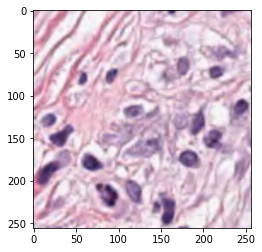

The T1 cells count is 0


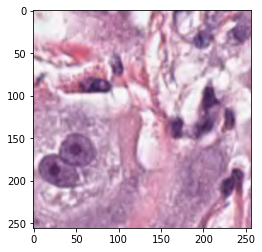

The T1 cells count is 4


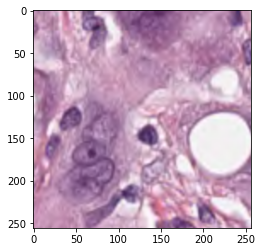

The T1 cells count is 8


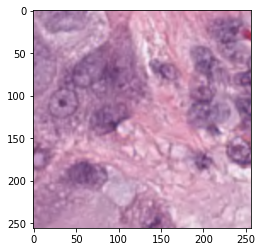

The T1 cells count is 17


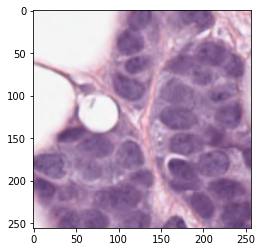

The T1 cells count is 29


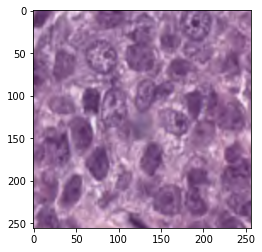

The T1 cells count is 38


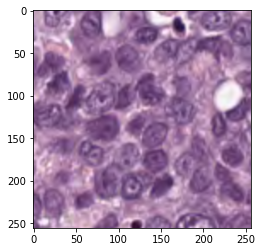

The T1 cells count is 49


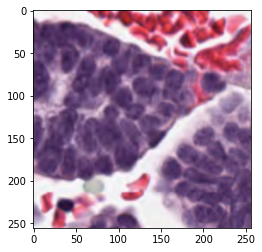

The T1 cells count is 52


In [105]:
for i in ind_:
    plt.imshow(x1[i])
    plt.show()
    print("The T1 cells count is", y1[i][0])

#### It could be concluded from the plots above that the higher the cell count the more purple cells. Also, the shapes of cells are more clear at the samples with high cell count.




### iii. For each fold, plot the histogram of counts of each cell type separately (6 plots in total). How many images have counts within each of the following bins? 

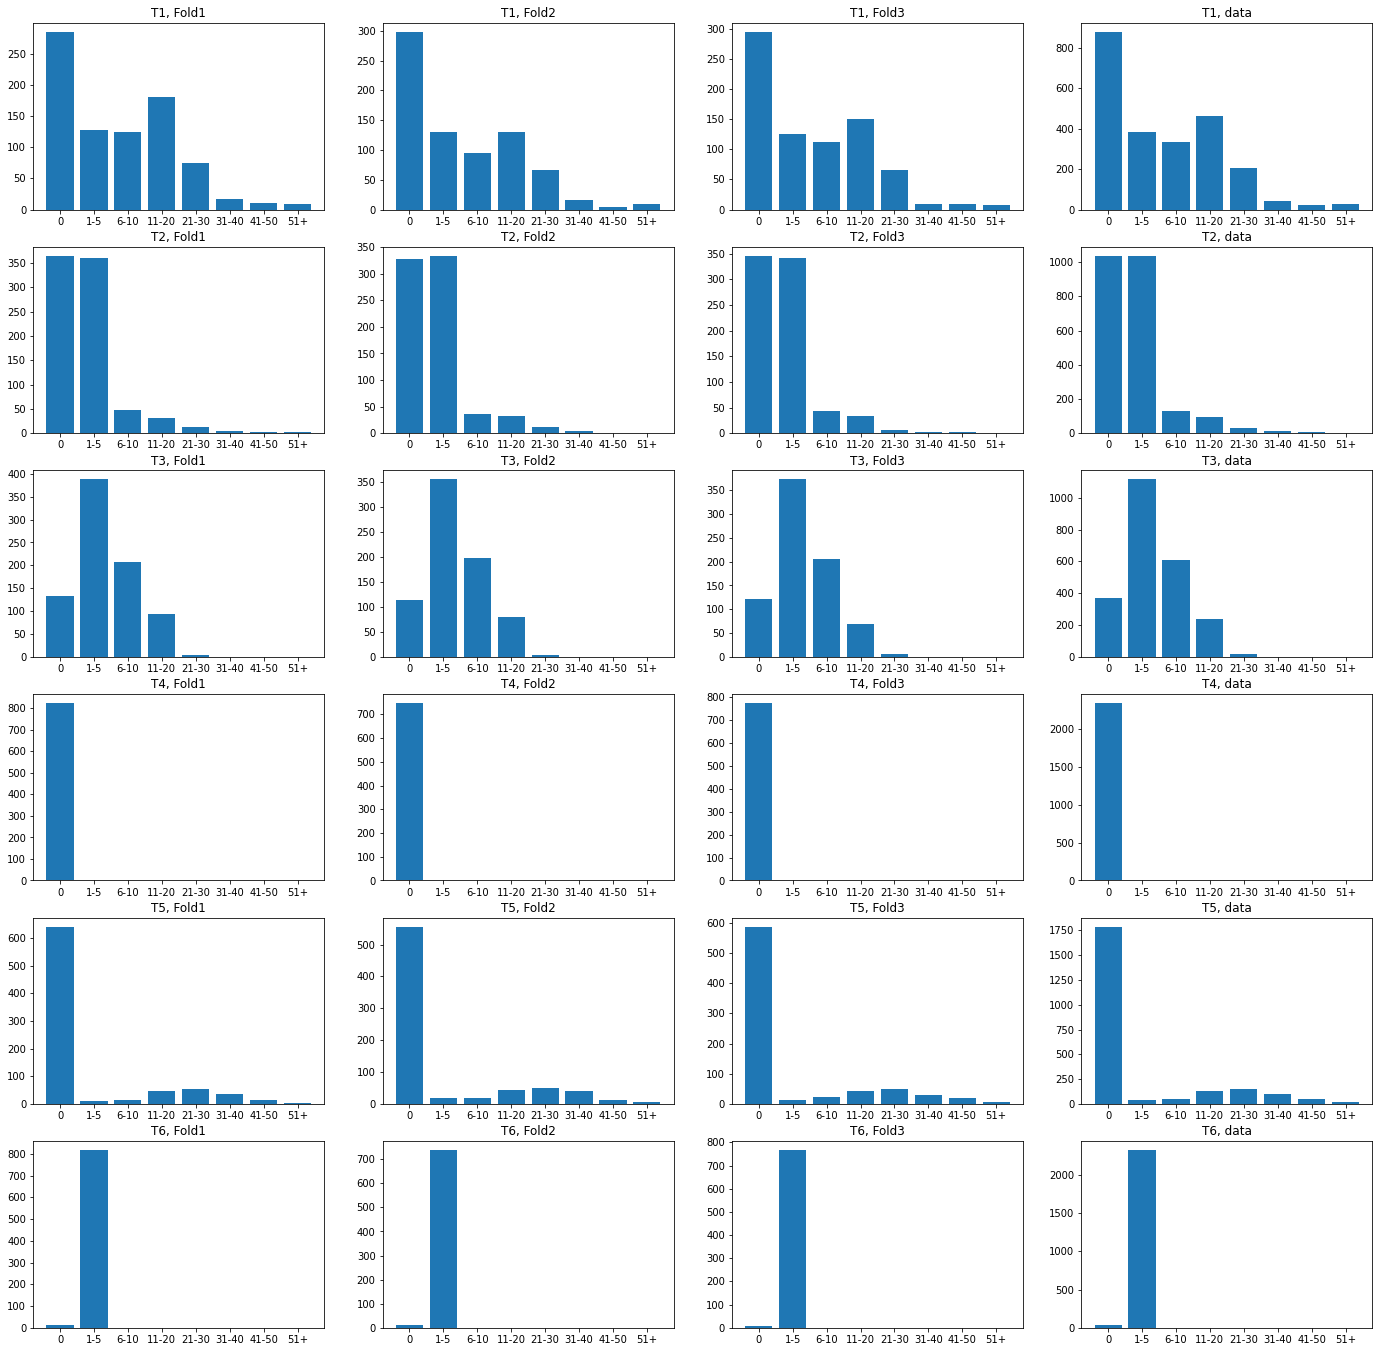

In [106]:

fig, axs = plt.subplots(6, 4, figsize=(24, 24))
for i in range(6):
    t1,t2,t3,t4 = [],[],[],[]
    for bound in [(0,0),(1,5),(6,10),(11,20),(21,30),(31,40),(41,50),(51, 1000)]:
        t1.append(getsamplescount(bound, data=y1[:, i]))
        t2.append(getsamplescount(bound, data=y2[:, i]))
        t3.append(getsamplescount(bound, data=y3[:, i]))
    t4 = [t1[j] + t2[j] + t3[j] for j in range(len(t1))]

    bins = ["0", "1-5", "6-10", "11-20", "21-30", "31-40", "41-50", "51+"]
    axs[i, 0].set_title("T" + str(i+1) + ", Fold1" )
    axs[i, 1].set_title("T" + str(i+1) + ", Fold2" )
    axs[i, 2].set_title("T" + str(i+1) + ", Fold3" )
    axs[i, 3].set_title("T" + str(i+1) + ", data" )
    axs[i, 0].bar(height = t1,  x = bins)
    axs[i, 1].bar(height = t2, x = bins)
    axs[i, 2].bar(height = t3, x = bins)
    axs[i, 3].bar(height = t4, x = bins)

  
            
 

In [107]:
for i in range(6):
    print("T", i+1)
    total = 0
    for bound in [(0,0),(1,5),(6,10),(11,20),(21,30),(31,40),(41,50),(51, 1000)]:
        num = getsamplescount(bound, data=counts[:, i])
        print("In the bin", bound, "there are", num, "images")

T 1
In the bin (0, 0) there are 878 images
In the bin (1, 5) there are 382 images
In the bin (6, 10) there are 332 images
In the bin (11, 20) there are 462 images
In the bin (21, 30) there are 205 images
In the bin (31, 40) there are 43 images
In the bin (41, 50) there are 23 images
In the bin (51, 1000) there are 26 images
T 2
In the bin (0, 0) there are 1038 images
In the bin (1, 5) there are 1035 images
In the bin (6, 10) there are 129 images
In the bin (11, 20) there are 97 images
In the bin (21, 30) there are 31 images
In the bin (31, 40) there are 12 images
In the bin (41, 50) there are 5 images
In the bin (51, 1000) there are 4 images
T 3
In the bin (0, 0) there are 370 images
In the bin (1, 5) there are 1116 images
In the bin (6, 10) there are 609 images
In the bin (11, 20) there are 241 images
In the bin (21, 30) there are 15 images
In the bin (31, 40) there are 0 images
In the bin (41, 50) there are 0 images
In the bin (51, 1000) there are 0 images
T 4
In the bin (0, 0) there

### iv. Pre-processing: Convert and show a few images from RGB space to HED space and show the H-channel which should indicate cellular nuclei.

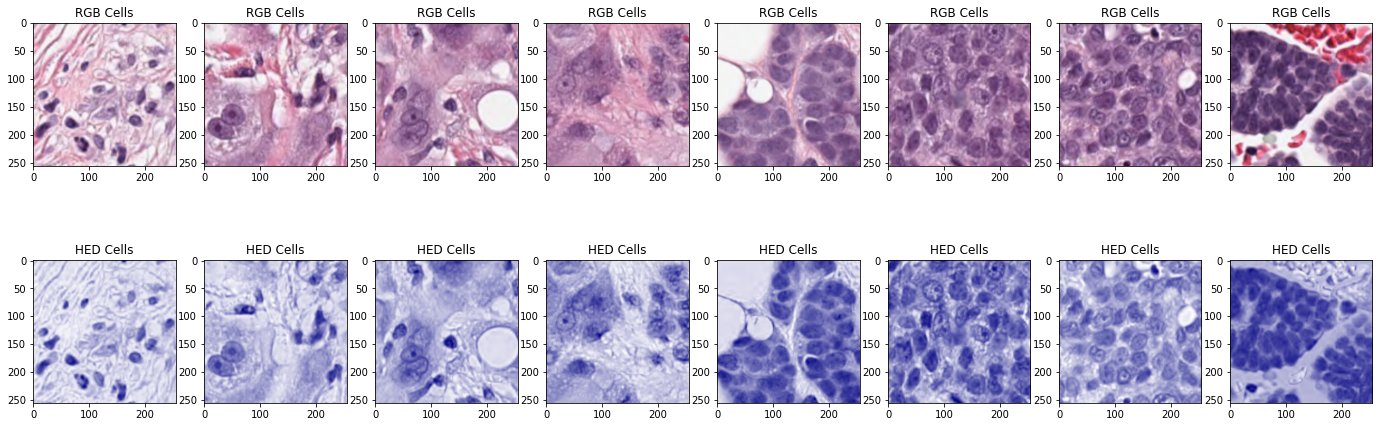

In [108]:

images_ = [x1[(i)] for i in ind_]
hed_images = [rgb2hed(img) for img in images_]
# H  channel
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])

fig, ax = plt.subplots(2, 8, figsize=(8 * 3,8))
for j in range(8):
    ax[0,j].imshow(images_[j])
    ax[0,j].title.set_text("RGB Cells")
    ax[1,j].imshow(hed_images[j][:,:,0], cmap=cmap_hema)
    ax[1,j].title.set_text("HED Cells")


### v. Do a scatter plot of the average of the H-channel for each image vs. its cell count of a certain type for images in Fold-1 (6 plots in total). Do you think this feature would be useful in your regression model? Explain your reasoning. 

In [109]:
def geth(img):
    return rgb2hed(img)[:,:,0]

In [110]:
def avgh(x = x1, y = y1, subsample = False):
    cells = [ y[i] for i in range(len(x))]
    avg_ = [rgb2hed(x[i])[:,:,0].mean() for i in range(len(x))]
    return (cells,avg_)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


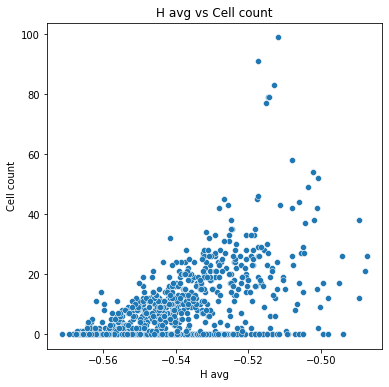

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


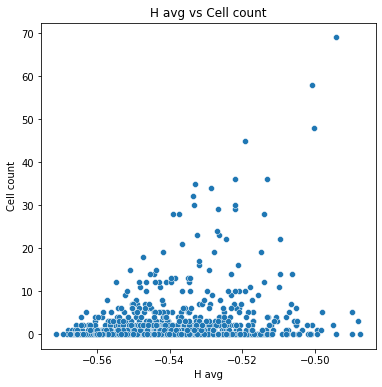

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


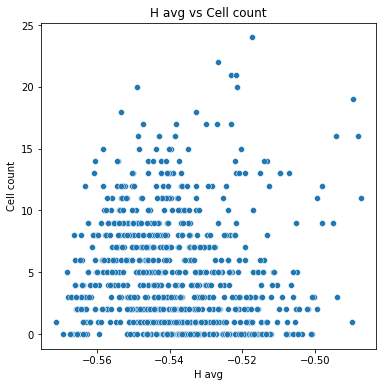

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


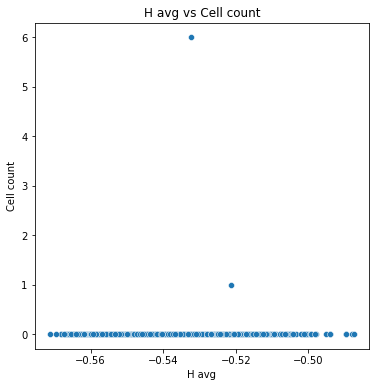

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


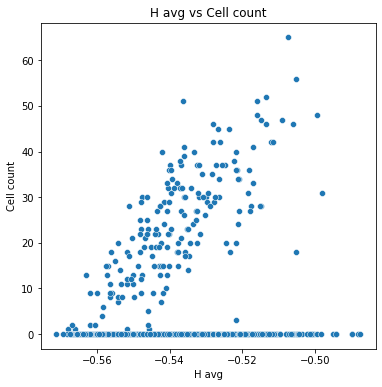

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


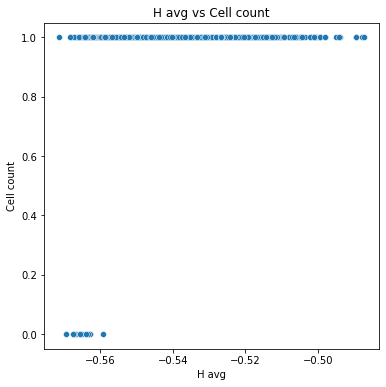

In [111]:
for i in range(6):
    cells, avg_ = avgh(y = y1[:,i])
    plt.figure(figsize=(6,6))
    plt.title("H avg vs Cell count")
    sns.scatterplot(avg_,cells)
    plt.ylabel("Cell count")
    plt.xlabel("H avg")
    plt.show()

#### T4 and T6 for the average of the H channel of an image could be useful. First of all, in the given dataset the value for type T4 is equal to zero for almost all samples. For T6, if avg h is more than -0.56 there is no possibility that T6 cell count is equal to zero. 



### vi. What performance metrics can you use for this problem? Which one will be the best performance metric for this problem? Please give reasoning. 

Since this is a regression task, the most commonly used performance metrics are:

- Mean Squared Error(MSE). It shows the sum of the squares of the difference between true and predicted values. It is very sensitive to outliers due to the squaring of the difference.
- Mean Absolute Error. It is absolute difference between true and predicted valuse. 
- Root Mean Squared Error(RMSE). It is the square root of MSE.
- R^2 score. It is normalised version of MSE and gives a ratio of how good the model is compared to how good the naive mean model is.

The dataset is imbalanced, so common metrics as accuracy and etc are not considered. Since the plots above show outliers, MAE would be chosen as the main metric. It is less sensitive to outliers compared to the other metrics. 

## Question No. 2: (Feature Extraction and Classical Regression)

### i. Extract features from a given image. Specifically, calculate the:
- a. average of the “H”, red, green and blue channels
- b. variance of the “H”, red, green and blue channels
- c. entropy of the “H”, red, green and blue channels
- d. Any other features that you think can be useful for this work. Describe your reasoning for using these features. 

In [113]:
def makevector(img):
    h = geth(img)
    m = np.zeros((256,256,4))
    m[:,:,0:3] = img
    m[:,:,3] = h
    vect = []
    for i in range(4):
        img_ = m[:,:,i]
        mean_ = np.mean(img_)
        var_ = np.var(img_)
        entr_ = entropy(img_.ravel())
        vect.extend([mean_,var_,entr_])
    return vect

In [114]:
data = []
for img in images:
    vect = makevector(img)
    data.append(vect)
col = ["R","G","B","H"]
feature = ["Mean","Var","Entropy"]
columns = [i + " " + j for i in col for j in feature]
df = pd.DataFrame(data=data,columns=columns)
print((df))

          R Mean        R Var  R Entropy  ...    H Mean     H Var  H Entropy
0     194.882919  1399.260020  11.070464  ... -0.539074  0.000933  11.088712
1     189.602707  1221.094279  11.072637  ... -0.534096  0.000786  11.088957
2     182.973572   821.075290  11.077667  ... -0.531469  0.000634  11.089222
3     186.574081   785.243383  11.078758  ... -0.533207  0.000531  11.089412
4     195.015030   760.524570  11.079951  ... -0.540401  0.000505  11.089478
...          ...          ...        ...  ...       ...       ...        ...
2346  195.212631  1956.342315  11.061110  ... -0.537826  0.001668  11.087351
2347  183.626495  1495.495931  11.066289  ... -0.529578  0.001381  11.087825
2348  199.640808  1515.186838  11.068020  ... -0.543875  0.001272  11.088097
2349  190.786728  1499.207582  11.067312  ... -0.534367  0.001304  11.087988
2350  194.552719  1473.158323  11.068293  ... -0.538460  0.001288  11.088042

[2351 rows x 12 columns]


In [79]:
# PCA
pca = PCA(n_components=1)
xflat = np.array([img.ravel() for img in images])
pca512 = pca.fit_transform(xflat)

In [80]:
# PCA randomized 
pcarand = PCA(n_components=1, svd_solver="randomized", random_state=100)
pca512rand = pcarand.fit_transform(xflat)

In [82]:
df["PCA"] = pca512
df["PCArand"] = pca512rand
#PCA is used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

In [83]:
coef = []
for col in df.columns:
    c = pearsonr(df[col], counts[:,0])
    coef.append((col,c[0]))
coef.sort(reverse=True, key = lambda x: abs(x[1]))
for x in coef:
    print(x[0], x[1])

H Mean 0.47722524647993286
R Mean -0.44447391539424425
PCA 0.33261880976511865
PCArand 0.3326188097648903
G Mean -0.2816126490388977
B Mean -0.26340570012530834
G Entropy -0.20220548574503192
R Entropy -0.16849335490019923
G Var 0.13645436812981387
B Entropy -0.127169618966914
H Entropy -0.11102409902583779
R Var 0.09590356835858725
B Var 0.0919718785588584
H Var 0.07985457715872393


In [84]:
def plot_scatter(name, data=df):
    colours = ["Red", "Green", "Blue", "Black"]
    f =[feature for feature in data.columns.values if name in feature]
    print(f)
    fig, ax = plt.subplots(1, 4, figsize=(4*4,4))
    ax[0].set_ylabel("Cell count")
    for i in range(4):
        sns.scatterplot(x = data[f[i]], y = counts[:,0], ax=ax[i], s=10, color = colours[i])
   

['R Mean', 'G Mean', 'B Mean', 'H Mean']


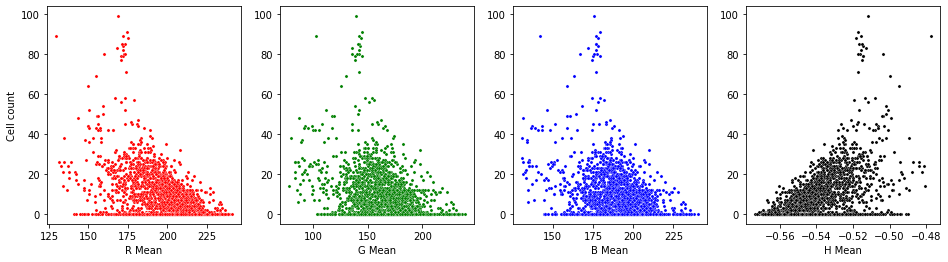

In [85]:
plot_scatter("Mean")

['R Var', 'G Var', 'B Var', 'H Var']


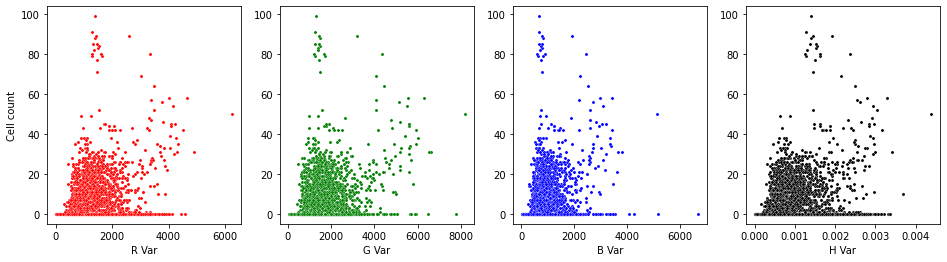

In [86]:
plot_scatter("Var")

['R Entropy', 'G Entropy', 'B Entropy', 'H Entropy']


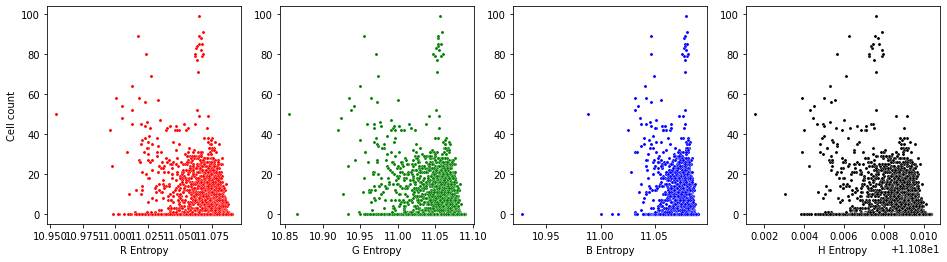

In [115]:
plot_scatter("Entropy")

#### According to the correlation coefficients' table, H avg and R mean are the most important for the target value (T1 cell count). However, the values are not high, they are even less than 0.5.


### ii. Try the following regression models with the features used in part-I. Plot the scatter plot between true and predicted counts for each type of regression model for the test data. Also, report your prediction performance in terms of RMSE, Pearson Correlation Coefficient, Spearman Correlation Coefficient and R2 score  on the test data. 
- a. Ordinary Least Squares (OLS) regression
- b. Multilayer Perceptron (in Sklearn or Keras or PyTorch).
- c. Support Vector Regression

In [116]:
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, EarlyStopping
from math import sqrt
from sklearn import metrics
import statsmodels.api as sm


In [ ]:

df = df.drop(columns=['PCA', 'PCArand']) #not going to use these features

In [117]:

xtrain = df[0:1575]
print("train shape =", xtrain.shape)



train shape = (1575, 12)


### a) OLS




In [118]:
lr = LinearRegression()
lr.fit(xtrain, counts[0:1575, 0])   
ols_predy = lr.predict(df[1576:])
ols_rmse = np.sqrt(mean_squared_error(counts[1576:, 0], ols_predy))
ols_pearson = pearsonr(counts[1576:, 0], ols_predy)
ols_spearman = spearmanr(counts[1576:, 0], ols_predy)
ols_r2 = r2_score(counts[1576:, 0], ols_predy)

print("RMSE: ", ols_rmse)
print("Pearson Correlation Coefficient: ", ols_pearson[0])
print("Spearman Correlation Coefficient: ", ols_spearman[0])
print("R2 score: ", ols_r2)

RMSE:  9.657385650506955
Pearson Correlation Coefficient:  0.5419138044980931
Spearman Correlation Coefficient:  0.5364176936204607
R2 score:  0.263475747896458


### b) Multilayer Perceptron


In [120]:
def createmodel(first_layer=50, second_layer=10, dropout_rate=0.2):
    mlp = Sequential()
    mlp.add(Dense(12, activation='relu', input_dim=12))
    mlp.add(Dropout(dropout_rate))
    mlp.add(Dense(first_layer, activation='relu'))
    mlp.add(Dropout(dropout_rate))
    mlp.add(Dense(1))
    mlp.compile(optimizer='adam', loss ='mean_squared_error', metrics=['mse'])
    return mlp

In [121]:
modelq2 = KerasRegressor(build_fn=createmodel, verbose=2)

In [122]:
# Define Grid Search Parameters
first_layer = [80,100]
second_layer = [-1,10]
dropout_rate = [0.05,0.25]
batch_size = [10, 20]
epochs = [50, 100]
param_grid = dict(first_layer=first_layer, second_layer=second_layer, dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=modelq2, param_grid=param_grid, n_jobs=-1, cv=3)

In [123]:
grid_result = grid.fit(xtrain, counts[0:1575, 0])

Epoch 1/100
158/158 - 1s - loss: 4287.0479 - mse: 4287.0479
Epoch 2/100
158/158 - 0s - loss: 1739.4241 - mse: 1739.4241
Epoch 3/100
158/158 - 0s - loss: 868.2079 - mse: 868.2079
Epoch 4/100
158/158 - 0s - loss: 540.7060 - mse: 540.7059
Epoch 5/100
158/158 - 0s - loss: 420.6608 - mse: 420.6608
Epoch 6/100
158/158 - 0s - loss: 311.5397 - mse: 311.5397
Epoch 7/100
158/158 - 0s - loss: 237.9695 - mse: 237.9695
Epoch 8/100
158/158 - 0s - loss: 221.2429 - mse: 221.2429
Epoch 9/100
158/158 - 0s - loss: 207.9860 - mse: 207.9860
Epoch 10/100
158/158 - 0s - loss: 190.9285 - mse: 190.9285
Epoch 11/100
158/158 - 0s - loss: 182.3448 - mse: 182.3448
Epoch 12/100
158/158 - 0s - loss: 178.0895 - mse: 178.0895
Epoch 13/100
158/158 - 0s - loss: 164.4027 - mse: 164.4027
Epoch 14/100
158/158 - 0s - loss: 158.1887 - mse: 158.1887
Epoch 15/100
158/158 - 0s - loss: 156.1416 - mse: 156.1416
Epoch 16/100
158/158 - 0s - loss: 153.6445 - mse: 153.6445
Epoch 17/100
158/158 - 0s - loss: 156.9764 - mse: 156.9764
Ep

In [124]:
print(grid_result.best_params_)

{'batch_size': 10, 'dropout_rate': 0.05, 'epochs': 100, 'first_layer': 100, 'second_layer': -1}


In [129]:
#Best MLP model
mlpq2 = grid_result

In [134]:
mlp_predy = mlpq2.predict(df[1576:]).ravel()
mlp_rmse = np.sqrt(mean_squared_error(counts[1576:, 0], mlp_predy))
mlp_pearson = pearsonr(counts[1576:, 0], mlp_predy)
mlp_spearman = spearmanr(counts[1576:, 0], mlp_predy)
mlp_r2 = r2_score(counts[1576:, 0], mlp_predy)

print("RMSE: ", mlp_rmse)
print("Pearson Correlation Coefficient: ", mlp_pearson[0])
print("Spearman Correlation Coefficient: ", mlp_spearman[0])
print("R2 score: ", mlp_r2)

78/78 - 0s
RMSE:  9.5707655
Pearson Correlation Coefficient:  0.5320177800328247
Spearman Correlation Coefficient:  0.4518613692564748
R2 score:  0.2766287429698512


### c) SVR

In [137]:
svrmodels, svrscor = [], []
for c in [0.1, 1, 10, 100]:
    svr = SVR(C=c, kernel="poly")
    svr.fit(xtrain[0:826], counts[0:826, 0])
    svrmodels.append(svr)
    svrscor.append(mean_squared_error(counts[827:1575, 0], svr.predict(xtrain[827:1575])))
svr_ = svrmodels[np.argmin(np.array(svrscor))]
svr_predy = svr_.predict(df[1576:])
svr_rmse = np.sqrt(mean_squared_error(counts[1576:, 0], svr_predy))
svr_pearson = pearsonr(counts[1576:, 0], svr_predy)
svr_spearman = spearmanr(counts[1576:, 0], svr_predy)
svr_r2 = r2_score(counts[1576:, 0], svr_predy)

print("RMSE: ", svr_rmse)
print("Pearson Correlation Coefficient: ", svr_pearson[0])
print("Spearman Correlation Coefficient: ", svr_spearman[0])
print("R2 score: ", svr_r2)

RMSE:  10.493183921795339
Pearson Correlation Coefficient:  0.3968402820001171
Spearman Correlation Coefficient:  0.3111936794730091
R2 score:  0.13047419932876458


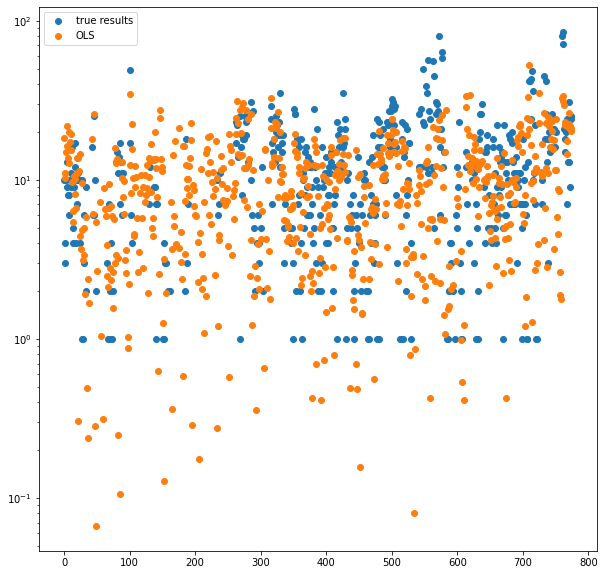

In [138]:
plt.figure(figsize=(10, 10))
plt.plot(counts[1576:, 0], "o", label="true results")
plt.plot(ols_predy, "o", label="OLS")
plt.legend()
plt.yscale("log")

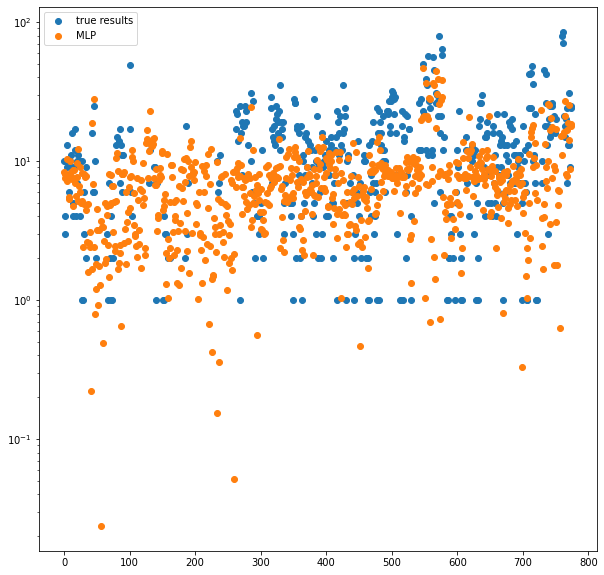

In [140]:
plt.figure(figsize=(10, 10))
plt.plot(counts[1576:, 0], "o", label="true results")
plt.plot(mlp_predy, "o", label="MLP")
plt.legend()
plt.yscale("log")

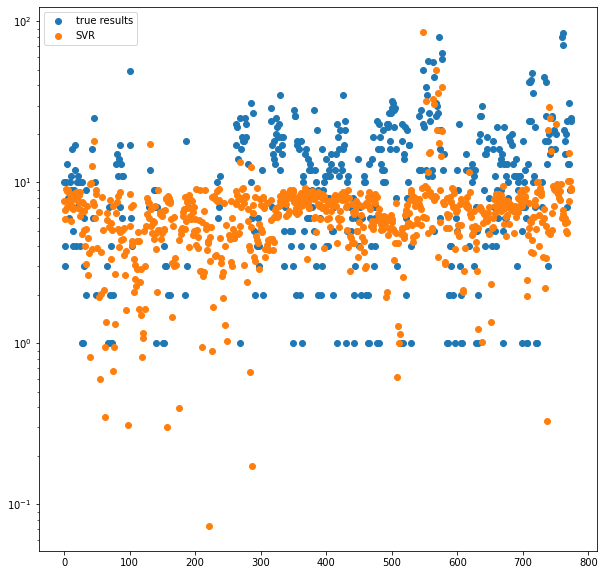

In [141]:
plt.figure(figsize=(10, 10))
plt.plot(counts[1576:, 0], "o", label="true results")
plt.plot(svr_predy, "o", label="SVR")
plt.legend()
plt.yscale("log")

## Question No. 3: (Using Convolutional Neural Networks) 


### i.

In [146]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 6.5MB/s 


In [147]:
from keras import applications
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
import keras
import keras.callbacks
from keras.callbacks import TensorBoard
import kerastuner as kt


In [148]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras import  optimizers, initializers
from keras.optimizers import SGD
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from kerastuner.tuners import RandomSearch


In [156]:
trainX = df[0:826]
trainY = counts[0:826, 0]
valX = df[827:1575]
valY = counts[827:1575, 0]
testX = df[1576:]
testY = counts[1576:, 0]


In [157]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(df[:1575])
scaled_val = scaled_train[827:1575]
scaled_train = scaled_train[0:826]


In [158]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int("units_1",
                     min_value=4,
                     max_value=64,
                     step=4),
        activation="relu",
        input_shape=(12,)))
    
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=4,
                                            max_value=64,
                                            step=4),
                               activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(
        optimizer=optimizers.SGD(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])),
        loss='mse',
        metrics=['mse'])
    return model

In [159]:
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=30,
    executions_per_trial=3,
    directory='./ann',
    project_name='helloworld')

In [160]:
tuner.search_space_summary()


Search space summary
Default search space size: 4
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 4, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 4, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


In [161]:
tuner.search(scaled_train, trainY,
             epochs=30,
             validation_data=(scaled_val, valY))

Trial 30 Complete [00h 00m 11s]
val_mse: 129.8258794148763

Best val_mse So Far: 43.80551020304362
Total elapsed time: 00h 05m 59s
INFO:tensorflow:Oracle triggered exit


In [162]:
scaled_test = scaler.fit_transform(df[1576:])

In [163]:
best_mlp = tuner.get_best_models(num_models=1)[0]
best_mlp.save("./best_mlp.h5")
#To load the model back, use mlp_AVE = keras.models.load_model("./best_mlp.h5").
# load the model
#mlp_AVE = keras.models.load_model("./best_mlp.h5")


In [164]:
history = best_mlp.fit(scaled_train, trainY,
              epochs=100, batch_size=128, 
             validation_data=(scaled_val, valY))

Epoch 1/100
7/7 [==============================] - 1s 35ms/step - loss: 38.4872 - mse: 38.4872 - val_loss: 48.5591 - val_mse: 48.5591
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 41.3006 - mse: 41.3006 - val_loss: 43.0006 - val_mse: 43.0006
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 35.8819 - mse: 35.8819 - val_loss: 42.0910 - val_mse: 42.0910
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 39.6119 - mse: 39.6119 - val_loss: 42.7111 - val_mse: 42.7111
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 38.2260 - mse: 38.2260 - val_loss: 43.5108 - val_mse: 43.5108
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 35.8842 - mse: 35.8842 - val_loss: 40.5317 - val_mse: 40.5317
Epoch 7/100
7/7 [==============================] - 0s 10ms/step - loss: 36.9670 - mse: 36.9670 - val_loss: 43.8210 - val_mse: 43.8210
Epoch 8/100
7/7 [==============================] - 0s 9ms/step - l

In [165]:
best_mlp_predy = best_mlp.predict(scaled_test).flatten()
best_mlp_rmse = np.sqrt(mean_squared_error(counts[1576:, 0], best_mlp_predy))
best_mlp_pearson = pearsonr(counts[1576:, 0], best_mlp_predy)
best_mlp_spearman = spearmanr(counts[1576:, 0], best_mlp_predy)
best_mlp_r2 = r2_score(counts[1576:, 0], best_mlp_predy)

print("RMSE: ", best_mlp_rmse)
print("Pearson Correlation Coefficient: ", best_mlp_pearson[0])
print("Spearman Correlation Coefficient: ", best_mlp_spearman[0])
print("R2 score: ", best_mlp_r2)

RMSE:  7.7743583
Pearson Correlation Coefficient:  0.7337877724662409
Spearman Correlation Coefficient:  0.7528719700745097
R2 score:  0.5226939274628106


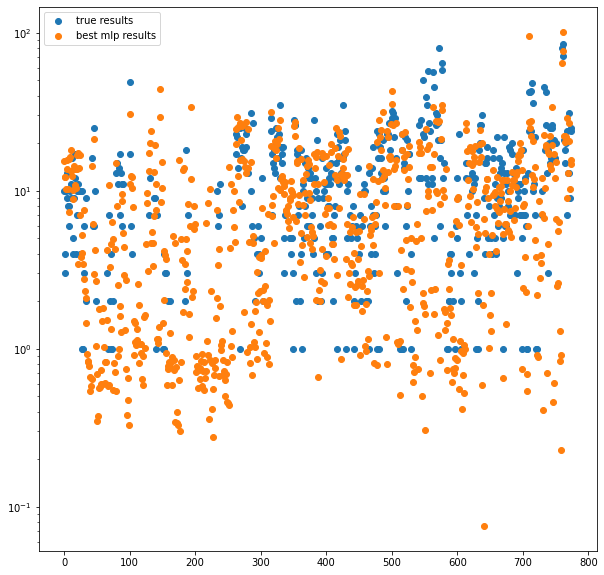

In [166]:
plt.figure(figsize=(10, 10))
plt.plot(counts[1576:, 0], "o", label="true results")
plt.plot(best_mlp_predy, "o", label="best mlp results")
plt.legend()
plt.yscale("log")

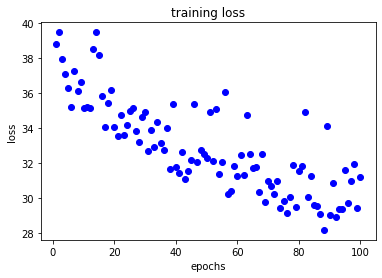

In [172]:
mse = history.history["mse"]
loss = history.history["loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo')
plt.title("training loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### ii.


In [173]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
print(df_scaled)

[[-0.11325566 -0.14543251  0.2183399  ...  0.0094484  -0.34275889
   0.3513765 ]
 [-0.40289525 -0.37979881  0.35865904 ...  0.32234373 -0.57867011
   0.55328679]
 [-0.76652834 -0.90599969  0.68356078 ...  0.48750321 -0.82202135
   0.77137003]
 ...
 [ 0.1477325   0.00706223  0.06046944 ... -0.29228325  0.20098124
  -0.15513259]
 [-0.33794723 -0.01395752  0.01473058 ...  0.30535187  0.25295086
  -0.24498767]
 [-0.13136839 -0.04822375  0.07812181 ...  0.04803719  0.22611931
  -0.20015164]]


In [174]:
def fold_results (bestmodel, trainx, trainy, valx, valy, testx, testy):
    history1 = bestmodel.fit( trainx, trainy,
              epochs=100, batch_size=128, 
              validation_data=(valx, valy)
             )
  
    print(bestmodel)
    pred = bestmodel.predict(testx).flatten()
    rmse1 = np.sqrt(mean_squared_error(testy, pred))
    pearson_coef1 = pearsonr(testy, pred)
    spearman_coef1 = spearmanr(testy, pred)
    r21 = r2_score(testy, pred)
    print("RMSE: ", rmse1)
    print("Pearson Correlation Coefficient: ", pearson_coef1[0])
    print("Spearman Correlation Coefficient: ", spearman_coef1[0])
    print("R2 score: ", r21)
    plt.figure(figsize=(10, 10))
    plt.plot(testy, "o", label="true results")
    plt.plot(pred, "o", label="best mlp results")
    plt.legend()
    plt.yscale("log")


In [175]:
fold1x = df_scaled[:826]
fold2x = df_scaled[827:1575]
fold3x = df_scaled[1576:]
fold1y = counts [:826,0]
fold2y = counts [827:1575,0]
fold3y = counts [1576:,0]

Epoch 1/100
7/7 [==============================] - 0s 22ms/step - loss: 34.3021 - mse: 34.3021 - val_loss: 46.9326 - val_mse: 46.9326
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 31.7525 - mse: 31.7525 - val_loss: 38.3316 - val_mse: 38.3316
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 27.6286 - mse: 27.6286 - val_loss: 37.6217 - val_mse: 37.6217
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 29.0905 - mse: 29.0905 - val_loss: 38.0764 - val_mse: 38.0764
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 28.5537 - mse: 28.5537 - val_loss: 39.0166 - val_mse: 39.0166
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 28.8465 - mse: 28.8465 - val_loss: 37.9173 - val_mse: 37.9173
Epoch 7/100
7/7 [==============================] - 0s 13ms/step - loss: 31.9274 - mse: 31.9274 - val_loss: 39.8859 - val_mse: 39.8859
Epoch 8/100
7/7 [==============================] - 0s 11ms/ste

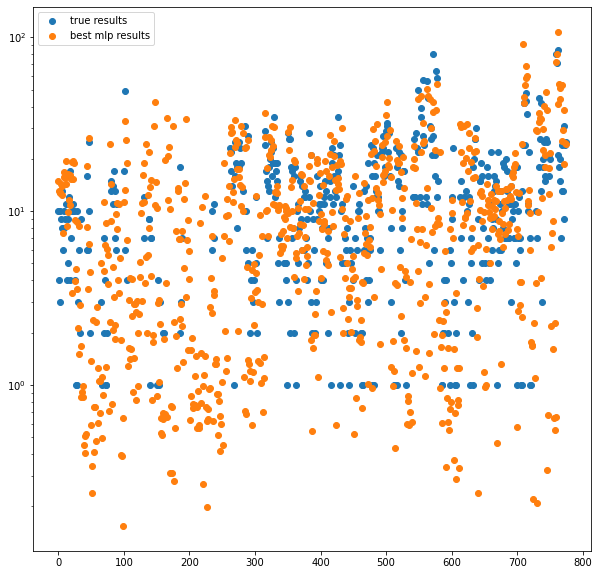

In [176]:
fold_results (best_mlp, fold1x, fold1y, fold2x, fold2y, fold3x, fold3y)

Epoch 1/100
6/6 [==============================] - 0s 25ms/step - loss: 44.6926 - mse: 44.6926 - val_loss: 54.3117 - val_mse: 54.3117
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 40.8221 - mse: 40.8221 - val_loss: 52.5796 - val_mse: 52.5796
Epoch 3/100
6/6 [==============================] - 0s 13ms/step - loss: 36.8276 - mse: 36.8276 - val_loss: 45.5880 - val_mse: 45.5880
Epoch 4/100
6/6 [==============================] - 0s 15ms/step - loss: 38.9341 - mse: 38.9341 - val_loss: 51.2429 - val_mse: 51.2429
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 33.5341 - mse: 33.5341 - val_loss: 46.5385 - val_mse: 46.5385
Epoch 6/100
6/6 [==============================] - 0s 13ms/step - loss: 32.3881 - mse: 32.3881 - val_loss: 51.0151 - val_mse: 51.0151
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 35.9498 - mse: 35.9498 - val_loss: 51.7462 - val_mse: 51.7462
Epoch 8/100
6/6 [==============================] - 0s 13ms/ste

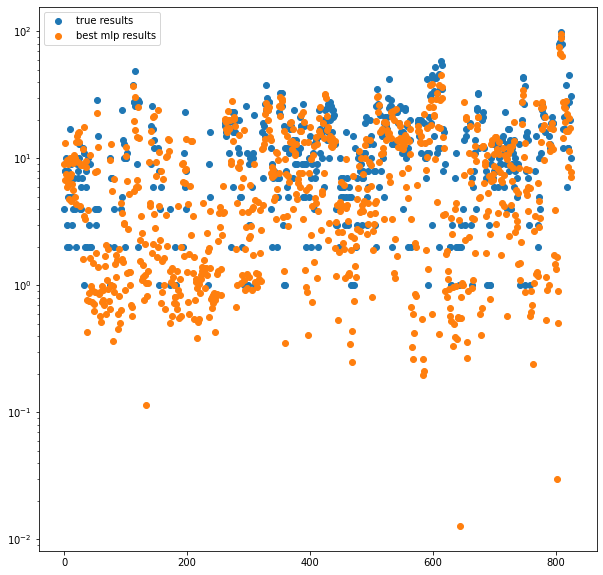

In [177]:
fold_results (best_mlp, fold2x, fold2y, fold3x, fold3y, fold1x, fold1y)

Epoch 1/100
7/7 [==============================] - 0s 22ms/step - loss: 57.3781 - mse: 57.3781 - val_loss: 59.3801 - val_mse: 59.3801
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 48.0234 - mse: 48.0234 - val_loss: 45.1087 - val_mse: 45.1087
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 32.0818 - mse: 32.0818 - val_loss: 43.0436 - val_mse: 43.0436
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 30.7265 - mse: 30.7265 - val_loss: 42.4768 - val_mse: 42.4768
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 28.3605 - mse: 28.3605 - val_loss: 42.2426 - val_mse: 42.2426
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 28.2930 - mse: 28.2930 - val_loss: 39.8699 - val_mse: 39.8699
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 26.9993 - mse: 26.9993 - val_loss: 43.1281 - val_mse: 43.1281
Epoch 8/100
7/7 [==============================] - 0s 12ms/ste

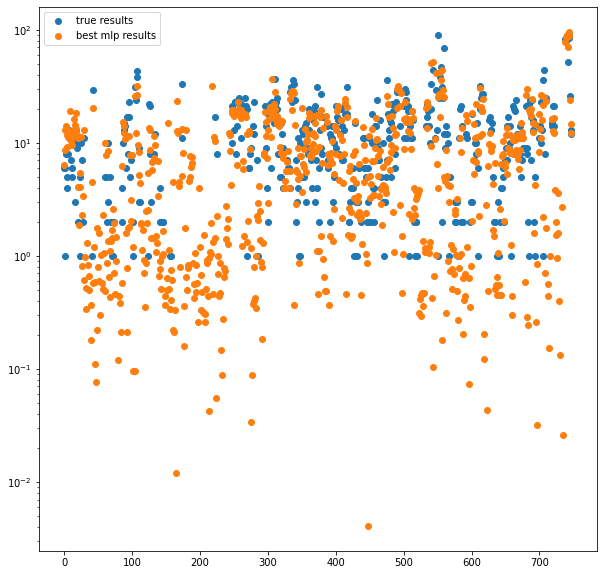

In [178]:
fold_results (best_mlp, fold1x, fold1y, fold3x, fold3y, fold2x, fold2y)

### iii.


In [179]:
fold1y_t2 = counts [:826,1]
fold2y_t2 = counts [827:1575,1]
fold3y_t2 = counts [1576:,1]

In [ ]:
tuner2 = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=30,
    executions_per_trial=3,
    directory='./2',
    project_name='helloworld')

In [ ]:
tuner2.search(fold1x, fold1y_t2,
             epochs=30,
             validation_data=(fold2x, fold2y_t2))

Trial 30 Complete [00h 00m 19s]
val_mse: 39.11343638102213

Best val_mse So Far: 25.555001576741535
Total elapsed time: 00h 09m 45s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_mlp2 = tuner2.get_best_models(num_models=1)[0]
best_mlp2.save("./best_mlp2.h5")

Epoch 1/100
7/7 [==============================] - 1s 43ms/step - loss: 26.6467 - mse: 26.6467 - val_loss: 25.0339 - val_mse: 25.0339
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 29.5923 - mse: 29.5923 - val_loss: 25.9727 - val_mse: 25.9727
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 23.3400 - mse: 23.3400 - val_loss: 22.8442 - val_mse: 22.8442
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 28.7364 - mse: 28.7364 - val_loss: 35.6248 - val_mse: 35.6248
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 51.3956 - mse: 51.3956 - val_loss: 24.5529 - val_mse: 24.5529
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 31.8450 - mse: 31.8450 - val_loss: 25.4410 - val_mse: 25.4410
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 20.7687 - mse: 20.7687 - val_loss: 23.4386 - val_mse: 23.4386
Epoch 8/100
7/7 [==============================] - 0s 12ms/ste

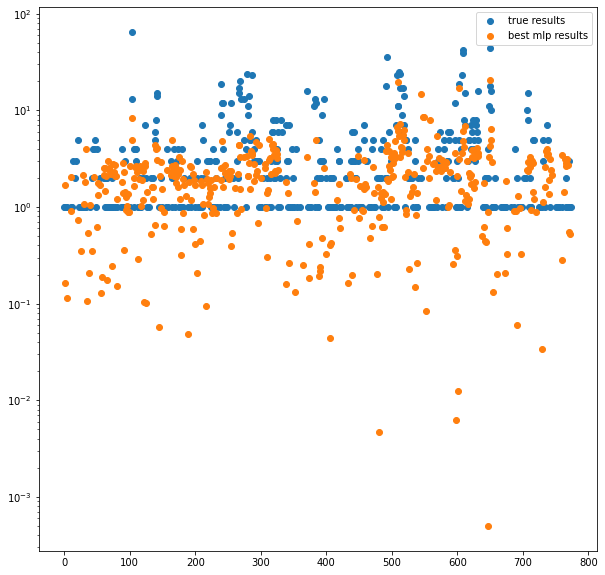

In [ ]:
fold_results (best_mlp2, fold1x, fold1y_t2, fold2x, fold2y_t2, fold3x, fold3y_t2)

Epoch 1/100
6/6 [==============================] - 0s 29ms/step - loss: 28.8743 - mse: 28.8743 - val_loss: 19.4301 - val_mse: 19.4301
Epoch 2/100
6/6 [==============================] - 0s 16ms/step - loss: 19.1691 - mse: 19.1691 - val_loss: 13.6516 - val_mse: 13.6516
Epoch 3/100
6/6 [==============================] - 0s 16ms/step - loss: 16.6506 - mse: 16.6506 - val_loss: 13.5139 - val_mse: 13.5139
Epoch 4/100
6/6 [==============================] - 0s 16ms/step - loss: 17.0908 - mse: 17.0908 - val_loss: 14.9584 - val_mse: 14.9584
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 13.8693 - mse: 13.8693 - val_loss: 15.1580 - val_mse: 15.1580
Epoch 6/100
6/6 [==============================] - 0s 16ms/step - loss: 15.1064 - mse: 15.1064 - val_loss: 13.5763 - val_mse: 13.5763
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 15.5356 - mse: 15.5356 - val_loss: 14.6650 - val_mse: 14.6650
Epoch 8/100
6/6 [==============================] - 0s 15ms/ste

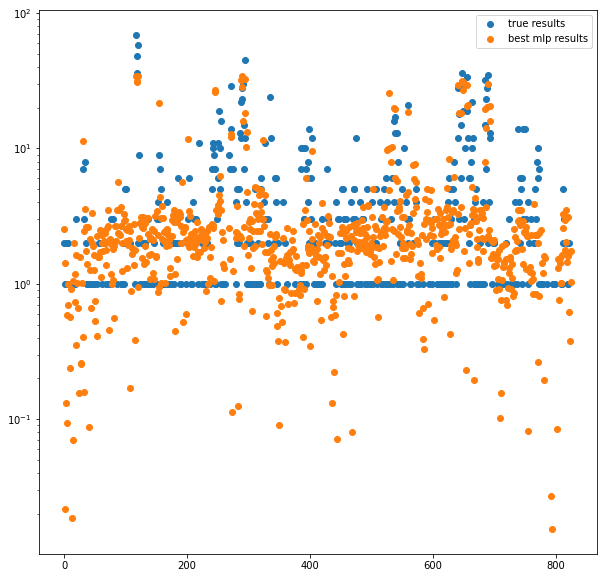

In [ ]:
fold_results (best_mlp2, fold2x, fold2y_t2, fold3x, fold3y_t2, fold1x, fold1y_t2)

Epoch 1/100
7/7 [==============================] - 0s 24ms/step - loss: 26.0230 - mse: 26.0230 - val_loss: 19.9470 - val_mse: 19.9470
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 26.3491 - mse: 26.3491 - val_loss: 32.3246 - val_mse: 32.3246
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 27.2461 - mse: 27.2461 - val_loss: 19.4954 - val_mse: 19.4954
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 24.5489 - mse: 24.5489 - val_loss: 18.8103 - val_mse: 18.8103
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 21.4627 - mse: 21.4627 - val_loss: 18.0106 - val_mse: 18.0106
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 20.8457 - mse: 20.8457 - val_loss: 17.3157 - val_mse: 17.3157
Epoch 7/100
7/7 [==============================] - 0s 13ms/step - loss: 23.5475 - mse: 23.5475 - val_loss: 22.2582 - val_mse: 22.2582
Epoch 8/100
7/7 [==============================] - 0s 13ms/ste

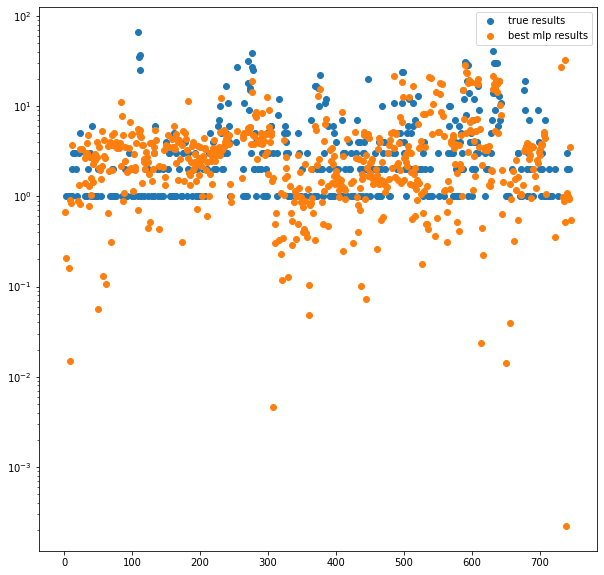

In [ ]:
fold_results (best_mlp2, fold1x, fold1y_t2, fold3x, fold3y_t2, fold2x, fold2y_t2)

In [ ]:
fold1y_t3 = counts [:826,2]
fold2y_t3 = counts [827:1575,2]
fold3y_t3 = counts [1576:,2]
tuner3 = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=30,
    executions_per_trial=3,
    directory='./3',
    project_name='helloworld')
tuner3.search(fold1x, fold1y_t3,
             epochs=30,
             validation_data=(fold2x, fold2y_t3))
best_mlp3 = tuner3.get_best_models(num_models=1)[0]
best_mlp3.save("./best_mlp3.h5")

Trial 30 Complete [00h 00m 18s]
val_mse: 14.410519282023111

Best val_mse So Far: 14.217630386352539
Total elapsed time: 00h 10m 13s
INFO:tensorflow:Oracle triggered exit


Epoch 1/100
7/7 [==============================] - 1s 46ms/step - loss: 13.0680 - mse: 13.0680 - val_loss: 14.1694 - val_mse: 14.1694
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 11.4774 - mse: 11.4774 - val_loss: 14.5882 - val_mse: 14.5882
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 12.4341 - mse: 12.4341 - val_loss: 14.1382 - val_mse: 14.1382
Epoch 4/100
7/7 [==============================] - 0s 15ms/step - loss: 11.9737 - mse: 11.9737 - val_loss: 14.3869 - val_mse: 14.3869
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 13.0808 - mse: 13.0808 - val_loss: 14.5114 - val_mse: 14.5114
Epoch 6/100
7/7 [==============================] - 0s 15ms/step - loss: 11.8787 - mse: 11.8787 - val_loss: 15.3407 - val_mse: 15.3407
Epoch 7/100
7/7 [==============================] - 0s 15ms/step - loss: 12.7248 - mse: 12.7248 - val_loss: 15.2250 - val_mse: 15.2250
Epoch 8/100
7/7 [==============================] - 0s 14ms/ste

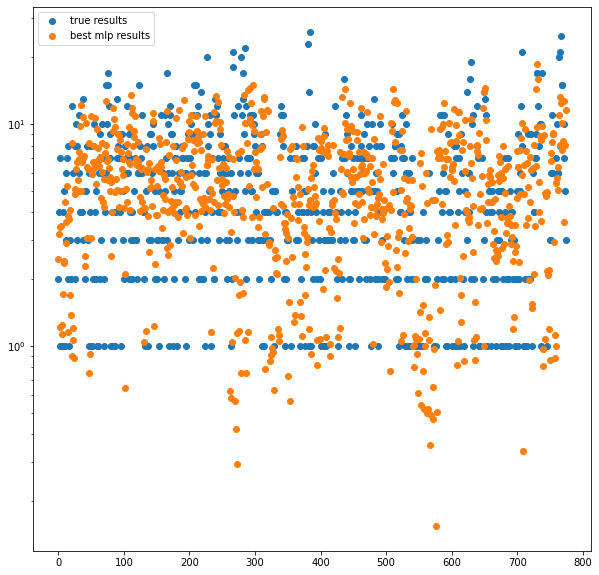

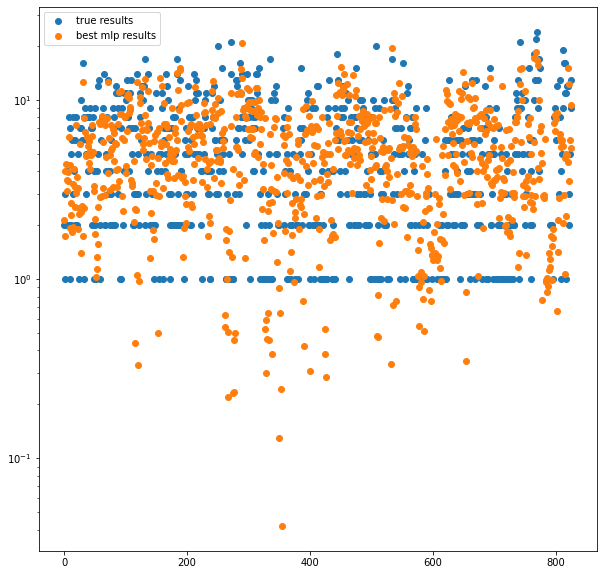

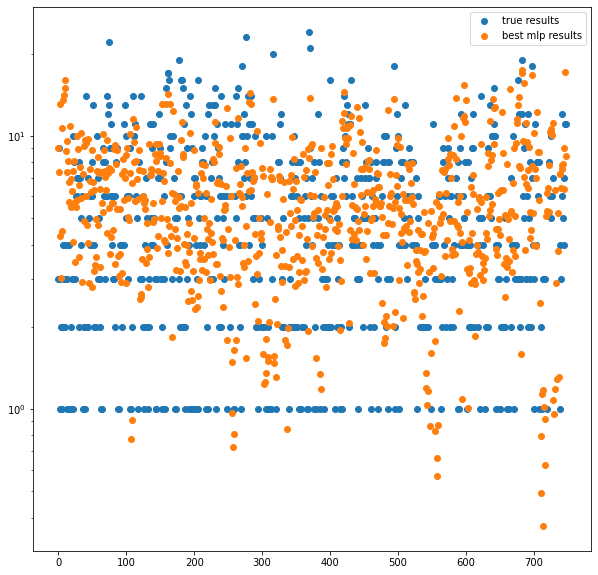

In [ ]:

fold_results (best_mlp3, fold1x, fold1y_t3, fold2x, fold2y_t3, fold3x, fold3y_t3)
fold_results (best_mlp3, fold2x, fold2y_t3, fold3x, fold3y_t3, fold1x, fold1y_t3)
fold_results (best_mlp3, fold1x, fold1y_t3, fold3x, fold3y_t3, fold2x, fold2y_t3)

In [ ]:
#t4
fold1y_t4 = counts [:826,3]
fold2y_t4 = counts [827:1575,3]
fold3y_t4 = counts [1576:,3]
tuner4 = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=30,
    executions_per_trial=3,
    directory='./4',
    project_name='helloworld')
tuner4.search(fold1x, fold1y_t4,
             epochs=30,
             validation_data=(fold2x, fold2y_t4))
best_mlp4 = tuner4.get_best_models(num_models=1)[0]
best_mlp4.save("./best_mlp4.h5")

Trial 30 Complete [00h 00m 18s]
val_mse: 0.04887342328826586

Best val_mse So Far: 0.04803082843621572
Total elapsed time: 00h 09m 45s
INFO:tensorflow:Oracle triggered exit


Epoch 1/100
7/7 [==============================] - 0s 22ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 2/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 3/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 7/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 8/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0442 - mse: 0.04

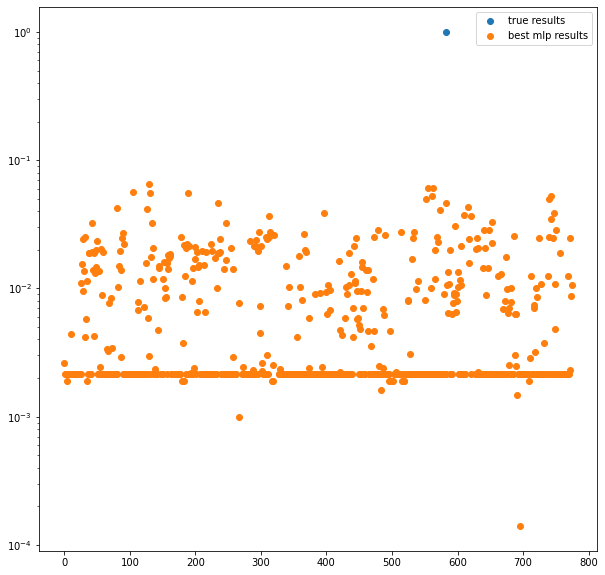

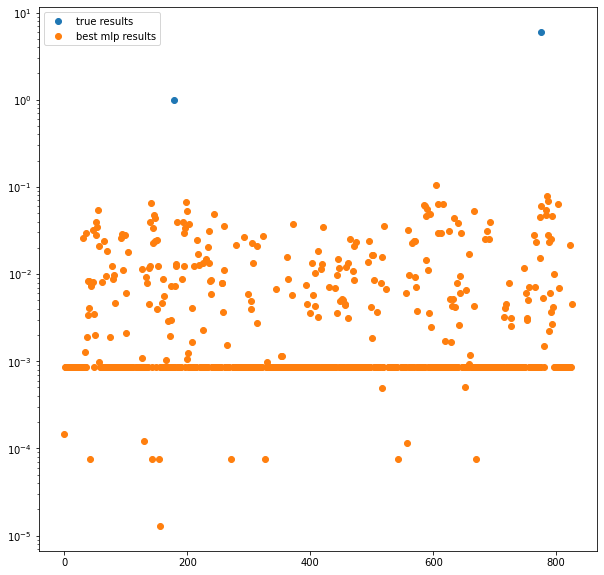

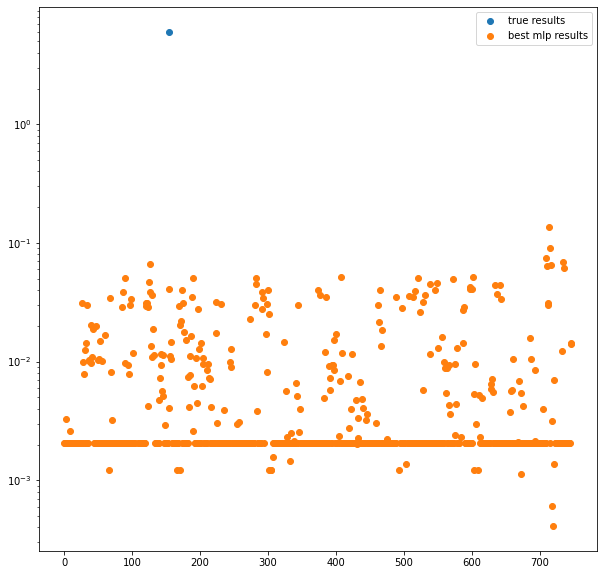

In [ ]:
fold_results (best_mlp4, fold1x, fold1y_t4, fold2x, fold2y_t4, fold3x, fold3y_t4)
fold_results (best_mlp4, fold2x, fold2y_t4, fold3x, fold3y_t4, fold1x, fold1y_t4)
fold_results (best_mlp4, fold1x, fold1y_t4, fold3x, fold3y_t4, fold2x, fold2y_t4)

In [ ]:
#t5
fold1y_t5 = counts [:826,4]
fold2y_t5 = counts [827:1575,4]
fold3y_t5 = counts [1576:,4]
tuner5 = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=30,
    executions_per_trial=3,
    directory='./5',
    project_name='helloworld')
tuner5.search(fold1x, fold1y_t5,
             epochs=30,
             validation_data=(fold2x, fold2y_t5))
best_mlp5 = tuner5.get_best_models(num_models=1)[0]
best_mlp5.save("./best_mlp5.h5")

Trial 30 Complete [00h 00m 19s]
val_mse: 157.05679575602213

Best val_mse So Far: 60.91327158610026
Total elapsed time: 00h 09m 46s
INFO:tensorflow:Oracle triggered exit


Epoch 1/100
7/7 [==============================] - 1s 43ms/step - loss: 45.0533 - mse: 45.0533 - val_loss: 61.7287 - val_mse: 61.7287
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 36.8884 - mse: 36.8884 - val_loss: 60.8880 - val_mse: 60.8880
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 32.7025 - mse: 32.7025 - val_loss: 99.7608 - val_mse: 99.7608
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 52.5729 - mse: 52.5729 - val_loss: 62.8585 - val_mse: 62.8585
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 40.3661 - mse: 40.3661 - val_loss: 58.6584 - val_mse: 58.6584
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 42.3831 - mse: 42.3831 - val_loss: 59.5635 - val_mse: 59.5635
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 37.2419 - mse: 37.2419 - val_loss: 58.5499 - val_mse: 58.5499
Epoch 8/100
7/7 [==============================] - 0s 13ms/ste

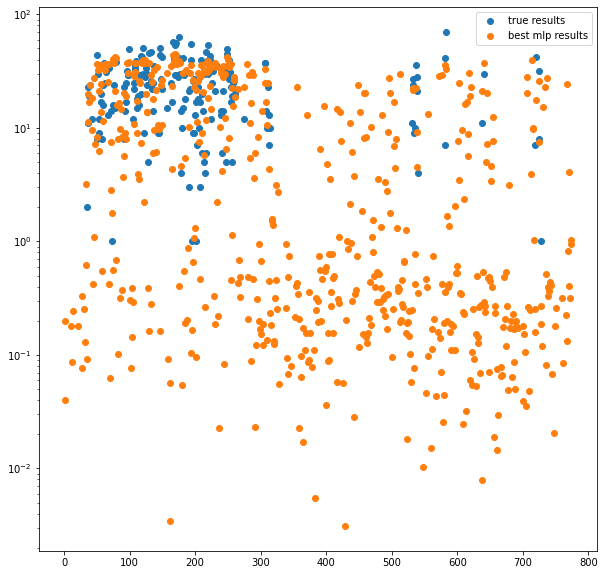

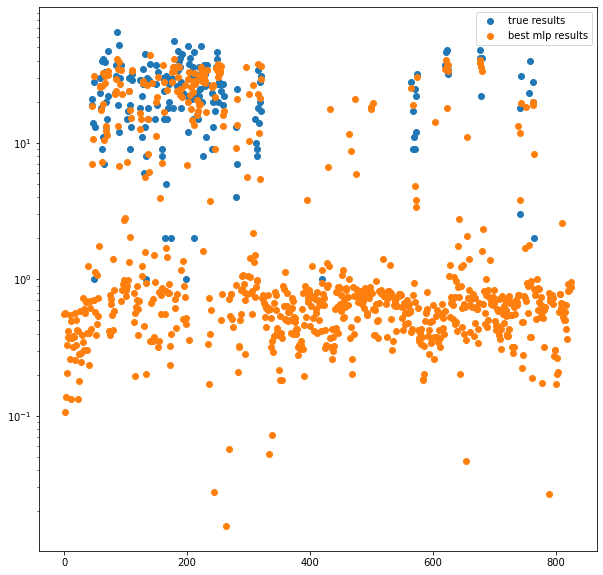

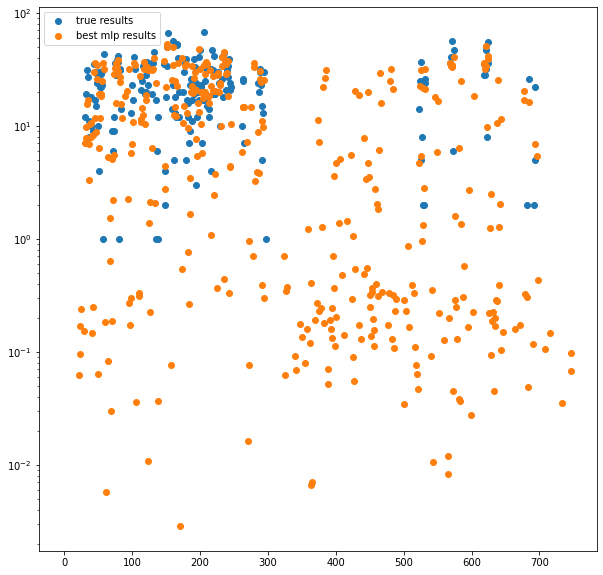

In [ ]:
fold_results (best_mlp5, fold1x, fold1y_t5, fold2x, fold2y_t5, fold3x, fold3y_t5)
fold_results (best_mlp5, fold2x, fold2y_t5, fold3x, fold3y_t5, fold1x, fold1y_t5)
fold_results (best_mlp5, fold1x, fold1y_t5, fold3x, fold3y_t5, fold2x, fold2y_t5)

In [ ]:
#t6
fold1y_t6 = counts [:826,5]
fold2y_t6 = counts [827:1575,5]
fold3y_t6 = counts [1576:,5]
tuner6 = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=30,
    executions_per_trial=3,
    directory='./6',
    project_name='helloworld')
tuner6.search(fold1x, fold1y_t6,
             epochs=30,
             validation_data=(fold2x, fold2y_t6))
best_mlp6 = tuner6.get_best_models(num_models=1)[0]
best_mlp6.save("./best_mlp6.h5")

Trial 30 Complete [00h 00m 18s]
val_mse: 0.012389407182733217

Best val_mse So Far: 0.012119309045374393
Total elapsed time: 00h 09m 49s
INFO:tensorflow:Oracle triggered exit


Epoch 1/100
7/7 [==============================] - 1s 40ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 7/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 8/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0066 - mse: 0.00

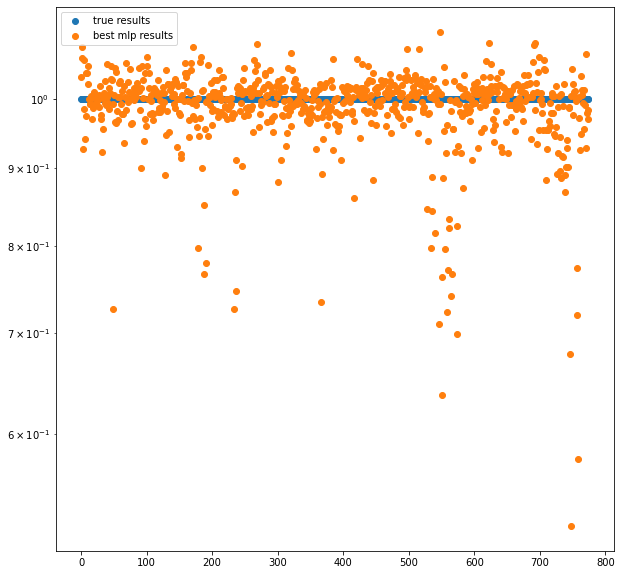

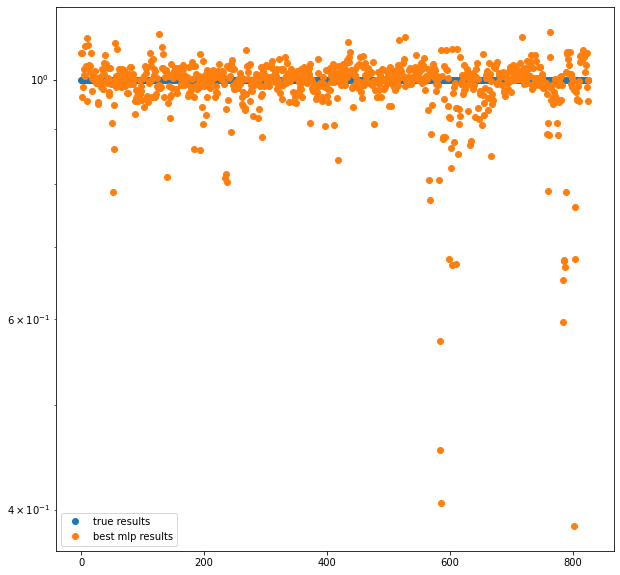

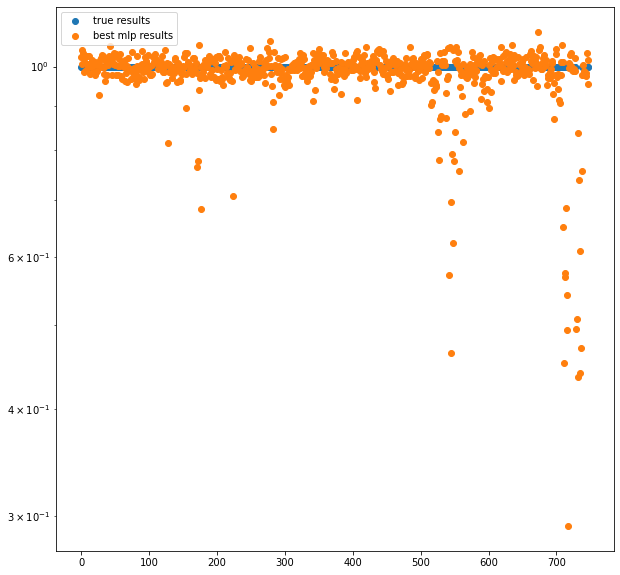

In [ ]:
fold_results (best_mlp6, fold1x, fold1y_t6, fold2x, fold2y_t6, fold3x, fold3y_t6)
fold_results (best_mlp6, fold2x, fold2y_t6, fold3x, fold3y_t6, fold1x, fold1y_t6)
fold_results (best_mlp6, fold1x, fold1y_t6, fold3x, fold3y_t6, fold2x, fold2y_t6)
